In [146]:
import xarray as xr
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (15,8)

import pandas as pd
import os
import numpy as np

#### Example: analyzing ERA5 relative humidity data

In [147]:
rh = xr.open_dataset("../data/humidity.nc").sel(expver=5)

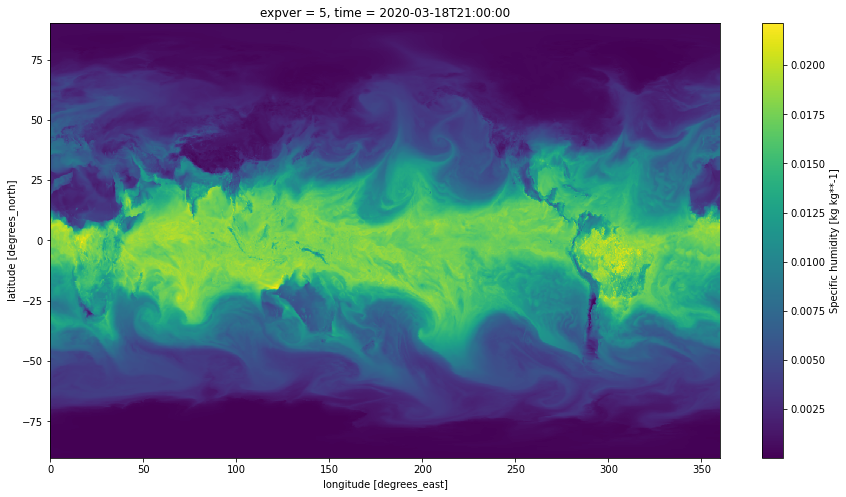

In [148]:
rh['q'].isel(time=-1).plot()
plt.savefig(f"../figures/rh_lastweek.png")

### Example: analyzing global deaths

From [Johns Hopkins University Dataset](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data)

In [149]:
dir_path = "../data/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"
daily = os.listdir(dir_path)

li = []
for day in daily:
    if ".csv" not in day: continue
    df_day = pd.read_csv(dir_path+day, index_col=None, header=0)
    df_day['date'] = day.split(".")[0]
    li.append(df_day)
    
df = pd.concat(li, axis=0, ignore_index=True, sort=False)
global_df = df.groupby('date').sum()
df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,date,Latitude,Longitude
0,Hubei,Mainland China,1/24/20 17:00,549.0,24.0,31.0,01-24-2020,NaN,NaN
1,Guangdong,Mainland China,1/24/20 17:00,53.0,NaN,2.0,01-24-2020,NaN,NaN
2,Zhejiang,Mainland China,1/24/20 17:00,43.0,NaN,1.0,01-24-2020,NaN,NaN
3,Beijing,Mainland China,1/24/20 17:00,36.0,NaN,1.0,01-24-2020,NaN,NaN
4,Chongqing,Mainland China,1/24/20 17:00,27.0,NaN,NaN,01-24-2020,NaN,NaN


Text(0, 0.5, 'Global deaths')

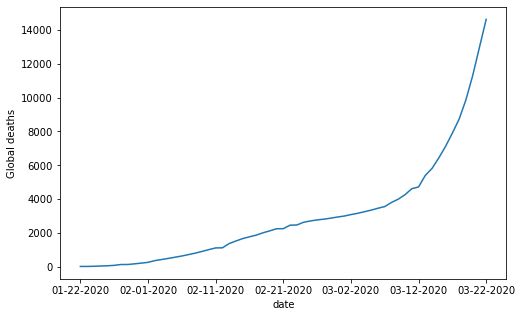

In [161]:
plt.figure(figsize=(8,5))
global_df['Deaths'].plot(x="date")
plt.ylabel("Global deaths")

### Example: exponential growth in the U.S.

We consider the growth rate of convirmed infections, starting after the 100th case in a Country/Region to avoid poor statistics of small numbers.

In [155]:
region_daily = df.groupby(["Country/Region", "date"]).sum()
emerged = np.argmin(np.abs(region_daily.loc['US']['Confirmed'] - 100.))

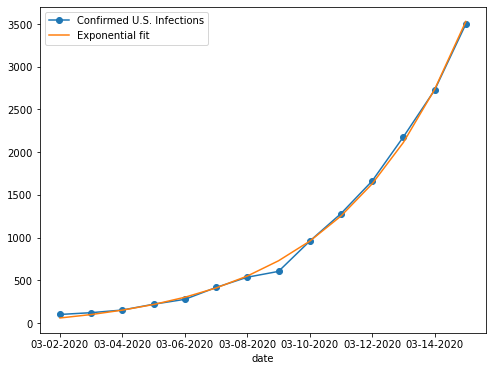

In [160]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(b * x) + c

y = region_daily.loc["US"][emerged:emerged+14]['Confirmed']
x = np.arange(0, len(y))

popt, pcov = curve_fit(func, x, y)

yfit = func(x, *popt)

plt.figure(figsize=(8,6))
y.plot(marker='o', label="Confirmed U.S. Infections")
plt.plot(x, yfit, label="Exponential fit")
plt.legend()

### Example: Mapping confirmed cases and specific humidity

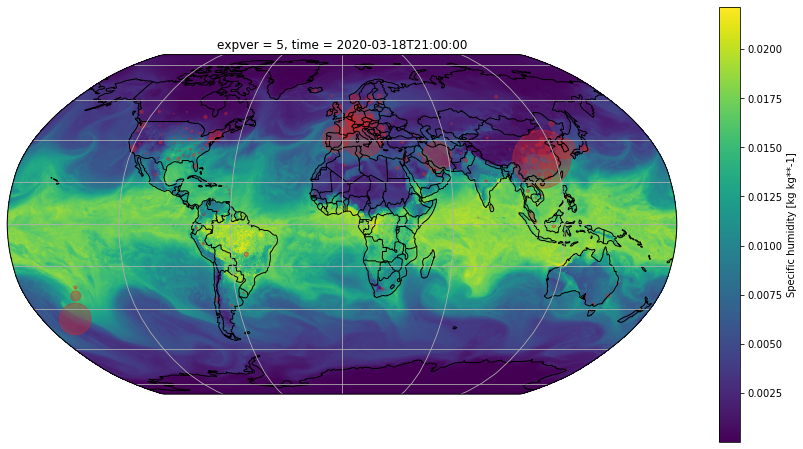

In [121]:
import cartopy
import cartopy.crs as ccrs
ortho = ccrs.Robinson(central_longitude=0) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

ex_date = "03-18-2020"
ex_df = df[df['date']==ex_date]

ax = plt.subplot(1, 1, 1, projection=ortho)

rh['q'].isel(time=-1).plot(ax=ax, transform=geo)
ax.scatter(ex_df['Longitude'], ex_df['Latitude'], ex_df['Confirmed']/20., color='C3', alpha=0.4, transform=geo)
ax.scatter([-149.25, -151.3, -160], [-30, -34, -45], [10., 100., 1000.], color='C3', alpha=0.4, transform=geo)

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.gridlines()

plt.savefig("../figures/rh_and_confirmed_cases.png", dpi=250, bbox_inches="tight")